This lab is adapted from the IBM Quantum Learning module “SExploring uncertainty” on the IBM Quantum platform
(see https://quantum.cloud.ibm.com/learning/en/modules/quantum-mechanics/exploring-uncertainty-with-qiskit).

Import libraries

In [37]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import (
    Batch,
    SamplerV2 as Sampler,
    EstimatorV2 as Estimator,
)
from qiskit_aer.primitives import SamplerV2, EstimatorV2
from qiskit_aer.noise import NoiseModel
from IPython.display import Image
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import math
from math import pi, sqrt
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
from mpl_toolkits.mplot3d import Axes3D 
from qiskit.visualization import plot_bloch_multivector

## Introduction

This lab looks at uncertainty in quantum mechanics as a fundamental feature of nature, not just a side effect of measurement. Certain pairs of observables, like position and momentum, or spin along different axes, cannot both be known with arbitrary precision. A state with well defined momentum is spread out in space, so its position is uncertain. A state that is sharply localized in space must be built from many different momenta. Similarly, a qubit that has a definite value along the z axis is an equal superposition of states with definite values along the x axis, and vice versa.

In this experiment quantum hardware is used to explore these incompatible observables, build intuition for how superposition and Fourier structure lead to uncertainty relations, and verify that the predicted bounds on uncertainty are satisfied in practice.

In [4]:
service = QiskitRuntimeService(name="oxford")

management.get:WARNING:2025-11-10 09:36:13,078: Loading saved account: oxford


In [5]:
# Use the least busy backend
backend = service.least_busy(min_num_qubits=127)
print(backend.name)

ibm_fez


In [6]:
# Import an estimator, this time from qiskit (we will import from Runtime for real hardware)
# Generate the noise model from the backend properties
noise_model = NoiseModel.from_backend(backend)
# classical sampler and estimator with real hardwares noise
noisy_sampler = SamplerV2(options={"backend_options": {"noise_model": noise_model}})
noisy_estimator = EstimatorV2(options={"backend_options": {"noise_model": noise_model}})

## Simple check of intuition

Noted in the 'Stern-Gerlach Measurement labs' if the first measurement is in $x$, a subsequent measurement in $z$ will give $|0\rangle$ or $|1\rangle$ with equal probability, since $|\pm\rangle_x=\frac{1}{\sqrt{2}}\left(|0\rangle \pm |1\rangle\right)$. This is tested by first measuring along $z$, then applying a Hadamard gate which swaps $z$ and $x$ axes, then making a measurement in $x$.

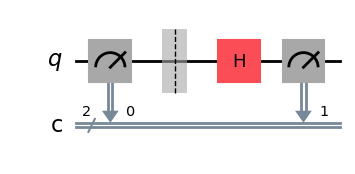

In [6]:
# Step 1: Map
 
# Import some general packages
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
 
# Add a first measurement
qc.measure(qr, cr[0])
qc.barrier()
 
# Change basis so that measurements made on quantum computer which normally tell us about z, now tell us about x.
qc.h(qr)
 
# Add a second measurement
qc.measure(qr, cr[1])
 
qc.draw("mpl")

In [10]:
fig = qc.draw("mpl")
fig.axes[0].set_title(r"Measure in Z, apply H (HZH = X), then measure in X")
fig.savefig("qc_z_x_measurement_circuit.png")  
plt.show()

In [22]:
# Step 2: Transpile
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
qc_isa = pm.run(qc)

In [13]:
# Step 3: Run the job on a real quantum computer
 
 
sampler = Sampler(mode=backend)
pubs = [qc_isa]
job = sampler.run(pubs)
res = job.result()
 
counts = res[0].data.c.get_counts()
 
# Run the job on the Aer simulator with noise model from real backend
 
# job = noisy_sampler.run([qc_isa])
# res=job.result()
# counts=res[0].data.c.get_counts()

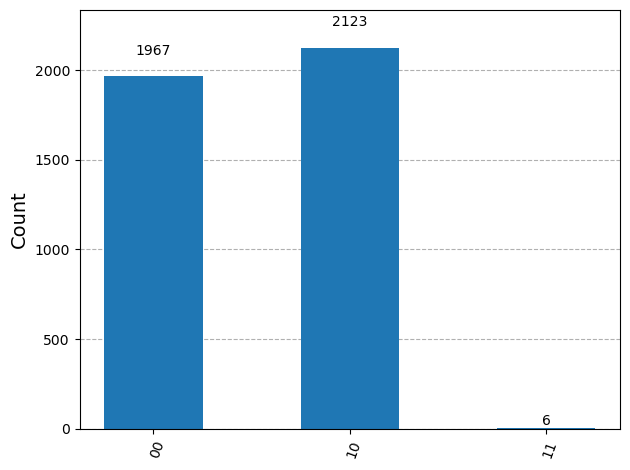

In [14]:
# Step 4: Post-process
 
 
plot_histogram(counts)

States in Qiskit are initialized in the $|0\rangle$ state by default, meaning (up to noisy hardware), all of the first measurements give '0'. As expected, when making the second measurement in $x$, '0' and '1' are measured with ~ equal probability.

What would happen if the measurements were made in the opposite order, i.e. $x$ and then $z$? 

First apply a Hadamard gate, which swaps $z$ and $x$ axes, this transforms $H|0\rangle=|+\rangle_x=\frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle\right)$. This means the first measurement should give '0' and '1' with equal probability. To make the second measurement in the $z$ axis, apply a second Hadamard gate and then measure. If the first measurement gave '0' or '1', the second measurement will give either '0' or '1' (independently) with equal probability, since $H|0\rangle=\frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle\right)$, and $H|1\rangle=\frac{1}{\sqrt{2}}\left(|0\rangle - |1\rangle\right)$.

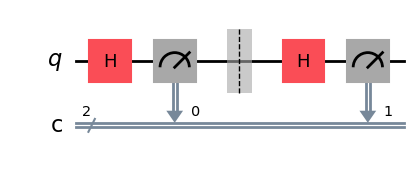

In [20]:
# Step 1:
 
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
 
# Change basis to measure along x.
qc.h(qr)
qc.measure(qr, cr[0])
qc.barrier()
 
# Change our basis back to z and make a second measurement
qc.h(qr)
qc.measure(qr, cr[1])
 
qc.draw("mpl")

In [25]:
fig = qc.draw("mpl")
fig.axes[0].set_title("Apply H, measure in X, then apply H, measure in Z")
fig.savefig("qc_x_z_measurement_circuit.png")  
plt.show()

In [21]:
# Step 2: Transpile the circuit for running on a quantum computer
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)

In [22]:
# Step 2: Transpile the circuit for running on a quantum computer
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)

In [23]:
# Step 3: Run the job on a real quantum computer
 
sampler = Sampler(mode=backend)
pubs = [qc_isa]
job = sampler.run(pubs)
res = job.result()
counts = res[0].data.c.get_counts()
 
# Run the job on the Aer simulator with noise model from real backend
# job = noisy_sampler.run([qc_isa])
# res=job.result()
# counts=res[0].data.c.get_counts()

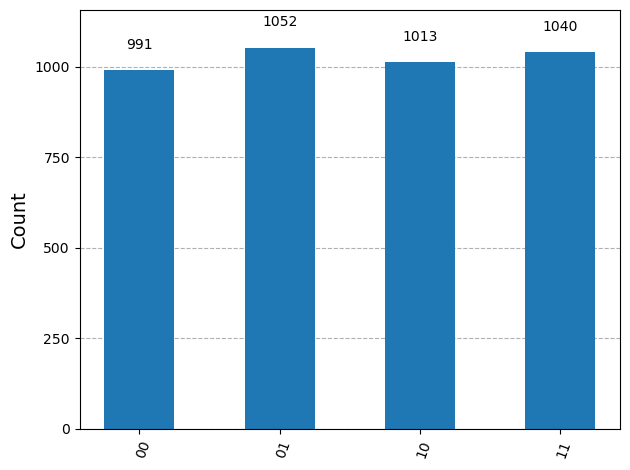

In [24]:
# Step 4: Post-process

 
plot_histogram(counts)

As expected, all four outcomes are equally likely.

## Calculating uncertainty

Uncertainty in an observable $S$ is defined as the standard deviation $\Delta S = \sqrt{\langle S^2 \rangle - \langle S \rangle^2}.$ For Pauli operators, $S^2 = I$, so $(\Delta S)^2 = 1 - \langle S \rangle^2.$

To begin, find the uncertainty of the observable $X$ in the state $|\psi\rangle=|+\rangle_y=|+i\rangle=1/\sqrt{2}\left(1,i\right)^T$. First look at the maths, and then confirm using quantum hardware.

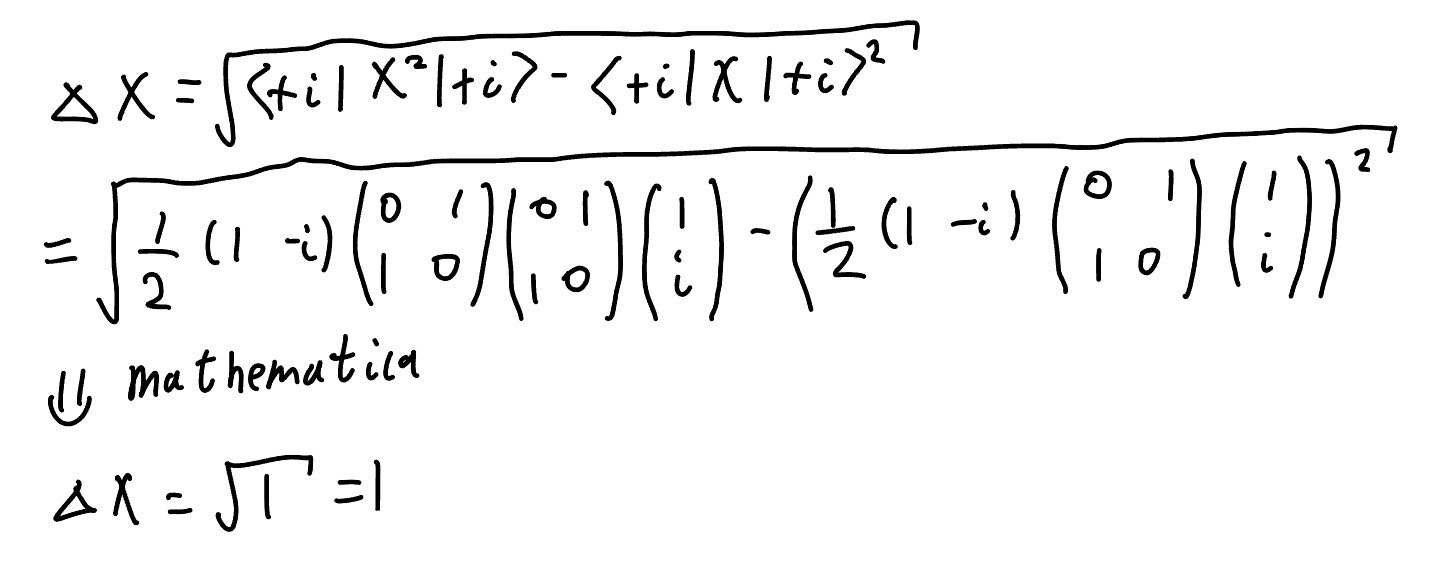

In [4]:
Image('del_x.jpeg')

$\Delta X=1$ mathematically, now compare experimentally. This is completed using $(\Delta X)^2 = 1 - \langle X \rangle^2,$ the estimator below calculates $\langle X\rangle$.

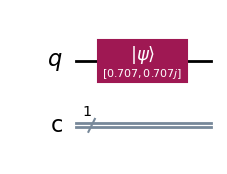

In [28]:
# Step 1: Map the problem into a quantum circuit
 
obs = SparsePauliOp("X") #observable is X
 
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
 
# Initialize the state
qc.initialize([1, 1j] / np.sqrt(2))
 
qc.draw("mpl")

In [30]:
# Step 2: Transpile the circuit
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
obs_isa = obs.apply_layout(layout=qc_isa.layout)
 
# Step 3: Run the circuit on a real quantum computer
 
 
estimator = Estimator(mode=backend)
job = estimator.run([[qc_isa, obs_isa]])
res = job.result()
 
# Run the job on the Aer simulator with noise model from real backend
# job = noisy_estimator.run([[qc_isa,obs_isa]])
# res=job.result()
 
# Step 4: Return the result in classical form, and analyze.
 
print(res[0].data.evs)

-0.018630647414997672


$(\Delta X)^2 \approx 1 - 0^2\Rightarrow\Delta X=1$, as expected.

For the same state, find the uncertainty of the observable $Z$. Since the state is an eigenstate of $Y$, the result is again expected to be $\Delta Z=1$.

In [31]:
# Step 1: Map the problem into a quantum circuit
 
obs = SparsePauliOp("Z")
 
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
 
# Initialize the state to |+>_y
qc.initialize([1, 1j] / np.sqrt(2))
 
 
# Step 2: Transpile the circuit
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
obs_isa = obs.apply_layout(layout=qc_isa.layout)
 
# Step 3: Run the circuit on a real quantum computer
 
estimator = Estimator(mode=backend)
pubs = [(qc_isa, obs_isa)]
job = estimator.run(pubs)
res = job.result()
 
# Run the job on the Aer simulator with noise model from real backend
# job = noisy_estimator.run([[qc_isa,obs_isa]])
# res=job.result()
 
# Step 4: Return the result in classical form, and analyze.
 
print(res[0].data.evs)

0.04844336207463964


$(\Delta Z)^2 \approx 1 - 0^2\Rightarrow\Delta Z=1$, as expected $\Rightarrow \Delta X \Delta Z=1$.

For the same state, find the uncertainty of the observable $Y$. Since the state is an eigenstate of $Y$, the result is expected to be $\Delta Y=0$.

In [32]:
# Step 1: Map the problem into a quantum circuit
 
obs = SparsePauliOp("Y")
 
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
 
# Initialize the state to |+>_y
qc.initialize([1, 1j] / np.sqrt(2))
 
 
# Step 2: Transpile the circuit
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
obs_isa = obs.apply_layout(layout=qc_isa.layout)
 
# Step 3: Run the circuit on a real quantum computer
 
estimator = Estimator(mode=backend)
pubs = [(qc_isa, obs_isa)]
job = estimator.run(pubs)
res = job.result()
 
# Run the job on the Aer simulator with noise model from real backend
# job = noisy_estimator.run([[qc_isa,obs_isa]])
# res=job.result()
 
# Step 4: Return the result in classical form, and analyze.
 
print(res[0].data.evs)

0.9635616801378031


$\langle Y\rangle\approx1\Rightarrow(\Delta Y)^2 \approx 1 - 1^2\Rightarrow\Delta Y=0$, as expected.

To check if this satisfies the uncertainty principle, consider the generalized uncertainty principle, $\Delta A\Delta B \ge \frac{1}{2} |\langle [A,B]\rangle|$ (with $A=X$ and $B=Z$).

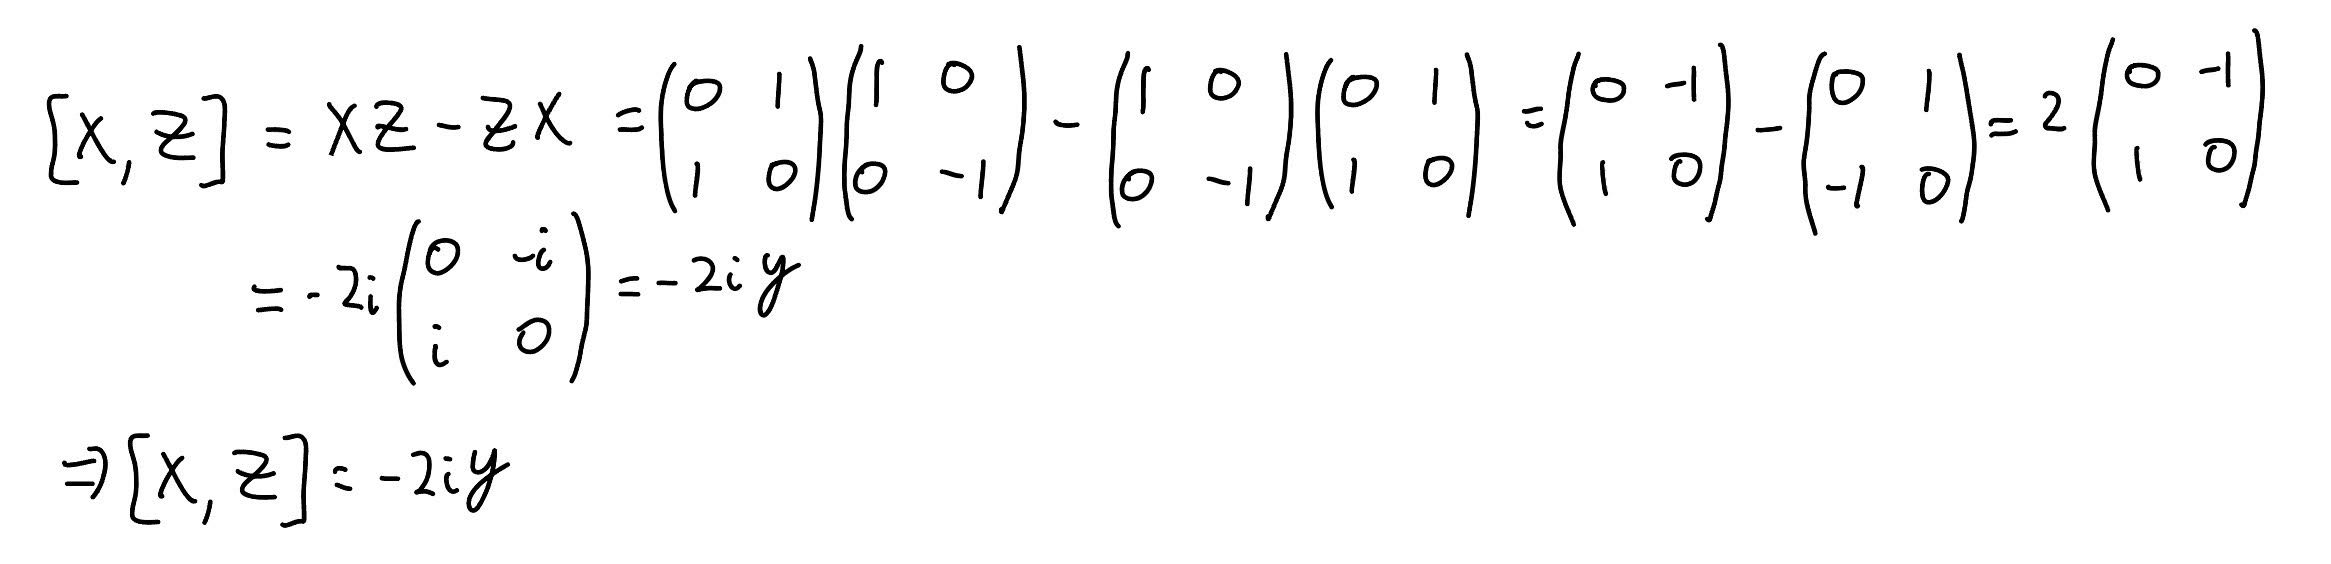

In [5]:
Image('com_xz.jpg')

$\Rightarrow\Delta X\Delta Z \ge |\langle Y\rangle|$, using the values found, $\Rightarrow\Delta X\Delta Z=1\ge|\langle Y\rangle|=1$, meaning we are exactly at the fundamental limit of lowest uncertainty in $X$ and $Z$.

Next, try and reduce $\Delta X\Delta Z$, and see if the uncertainty limit is still satisfied. This can actually be reduced to $0$ if the state is an eigenstate of either. Find the uncertainties of the observable $X$ and $Z$ (first and second observables, respectively) in the state $|\psi\rangle=|+\rangle_x=1/\sqrt{2}\left(1,1\right)^T$ (an eigenstate of $X$).

The expected result now is that $\langle X\rangle$ will equal $1$ since the state is $|+\rangle$, and $\langle Z\rangle$ will remain $0$, as $X$ and $Z$ do not commute.

In [33]:
# Step 1: Map the problem into a quantum circuit
 
obs1 = SparsePauliOp("X")
obs2 = SparsePauliOp("Z")
 
# Define registers
 
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
 
# Initialize the state
qc.initialize([1, 1] / np.sqrt(2))
 
# Step 2: Transpile the circuit
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
obs1_isa = obs1.apply_layout(layout=qc_isa.layout)
obs2_isa = obs2.apply_layout(layout=qc_isa.layout)
 
# Step 3: Run the circuit on a real quantum computer
 
with Batch(backend=backend) as batch:
#show the advantage of pubs, being able to measure both observables with one call 
    estimator = Estimator(mode=batch)
    pubs = [(qc_isa, obs1_isa), (qc_isa, obs2_isa)]
    job = estimator.run(pubs)
    res = job.result()
batch.close()
 
# Run the job on the Aer simulator with noise model from real backend
 
# job = noisy_estimator.run([[qc,obs1],[qc,obs2]])
# res=job.result()
 
# Step 4: Return the result in classical form, and analyze.
 
print("The expectation value of the first observable is: ", res[0].data.evs)
print("The expectation value of the second observable is: ", res[1].data.evs)

The expectation value of the first observable is:  0.9916051895192063
The expectation value of the second observable is:  -0.004070211142203002


As expected, $\langle X\rangle\approx1$, and $\langle Z\rangle\approx0$.

$\Rightarrow \Delta X\approx0,\text{ }\Delta Z\approx1\Rightarrow\Delta X\Delta Z\approx0$. This does not mean that the uncertainty limit has been violated, to test this, calculate $\langle Y\rangle$.

In [34]:
# Step 1: Map the problem into a quantum circuit
 
obs = SparsePauliOp("Y")
 
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
 
qc.initialize([1, 1] / np.sqrt(2))
 
 
# Step 2: Transpile the circuit
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
obs_isa = obs.apply_layout(layout=qc_isa.layout)
 
# Step 3: Run the circuit on a real quantum computer
 
estimator = Estimator(mode=backend)
pubs = [(qc_isa, obs_isa)]
job = estimator.run(pubs)
res = job.result()
 
# Run the job on the Aer simulator with noise model from real backend
# job = noisy_estimator.run([[qc_isa,obs_isa]])
# res=job.result()
 
# Step 4: Return the result in classical form, and analyze.
 
print(res[0].data.evs)

0.04676578980810776


$\langle Y\rangle\approx0\Rightarrow(\Delta Y)^2 \approx 1 - 0^2\Rightarrow\Delta Y=1$.

Mathematically get the same result.

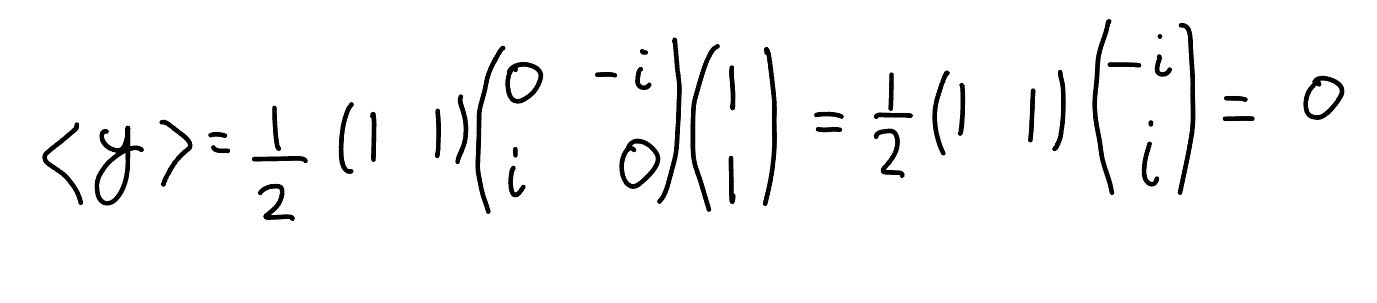

In [7]:
Image('exp_y.jpeg')

$\Rightarrow$For the state $|\psi\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}} = |+\rangle_x,\quad \langle X\rangle=1,\langle Z\rangle=0,\langle Y\rangle=0\Rightarrow$ the Bloch vector lies entirely in the $XZ$ plane with no $Y$ component.

$\Delta X\,\Delta Z=0 \ge |\langle Y\rangle| = 0$ is satisfied. This helps show that in an eigenstate of one Pauli operator, measurements of a non-commuting Pauli operator are completely uncertain.

$\Rightarrow$ eigenstates of a Pauli operator have $0$ uncertainty in that operator (expectation value with magnitude of $1$), and zero expectation value in the other two (maximal uncertainty).

## Testing uncertainty relations

So far, the uncertainty relations have only been shown for the states $|\psi\rangle = |+\rangle_y$ and $|\psi\rangle = |+\rangle_x$. For a more thorough evaluation, consider testing the relation for $|\psi\rangle = |0\rangle$, and then testing for rotations about $y$, increasing $\theta$ from $0$ to $2$.

In [44]:
# The calculation below uses approximately 3-4 minutes of QPU time.
# Step 1: Map the problem into a quantum circuit
 


 
# Specify observables
obs1 = SparsePauliOp("X")
obs2 = SparsePauliOp("Y")
obs3 = SparsePauliOp("Z")
 
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
 
# Rotate away from |0>
theta = Parameter("θ")
qc.ry(theta, 0)
 
params = np.linspace(0, 2, num=21)
 
# Step 2: Transpile the circuit
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
obs1_isa = obs1.apply_layout(layout=qc_isa.layout)
obs2_isa = obs2.apply_layout(layout=qc_isa.layout)
obs3_isa = obs3.apply_layout(layout=qc_isa.layout)
 
# Step 3: Run the circuit on a real quantum computer
 
#with Batch(backend=backend) as batch:
#    estimator = Estimator(mode=batch)
#    pubs = [(qc_isa, [[obs1_isa], [obs2_isa], [obs3_isa]], [params])]
#    job = estimator.run(pubs, precision=0.01)
#    res = job.result()
 
#batch.close()
 
# Run the job on the Aer simulator with noise model from real backend
 
job = noisy_estimator.run([(qc_isa, [[obs1_isa], [obs2_isa], [obs3_isa]], [params])])
res=job.result()

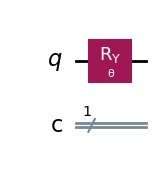

In [8]:
qc.draw("mpl")

In [45]:
# Step 4: Post-processing and classical analysis.
xs = res[0].data.evs[0]
ys = abs(res[0].data.evs[1])
zs = res[0].data.evs[2]
 
# Calculate uncertainties
 
delx = []
delz = []
prodxz = []
for i in range(len(xs)):
    delx.append(abs((1 - xs[i] * xs[i])) ** 0.5)
    delz.append(abs((1 - zs[i] * zs[i])) ** 0.5)
    prodxz.append(delx[i] * delz[i])

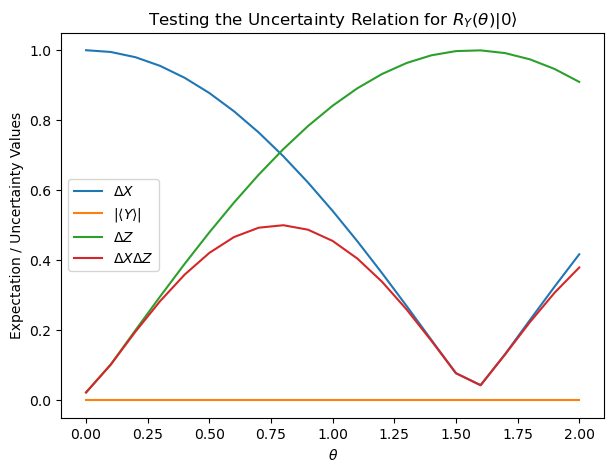

In [46]:
plt.figure(figsize=(7, 5))
plt.plot(params, delx, label=r"$\Delta X$")
plt.plot(params, ys, label=r"$|\langle Y \rangle|$")
plt.plot(params, delz, label=r"$\Delta Z$")
plt.plot(params, prodxz, label=r"$\Delta X \Delta Z$")

plt.xlabel(r"$\theta$")
plt.ylabel("Expectation / Uncertainty Values")
plt.title(r"Testing the Uncertainty Relation for $R_Y(\theta)|0\rangle$")
plt.legend()

plt.savefig("uncertainty_relation_vs_theta.png")
plt.show()

Varying $\theta$ continuously moves the Bloch vector through the $xz$ plane. Clearly the uncertainty relation $\Delta X\,\Delta Z \ge |\langle Y\rangle|$ is satisfied everywhere here (red curve always greater than or equal to orange curve).

This still is not completely general as the rotations are within the $xz$ plane, meaning $\langle Y\rangle$ will always equal $0$, and since $\Delta X, \Delta Z$ are both greater than or equal to $0$, the uncertainty relationship will always be satisfied. 

For a more general result, start with the state $|\psi\rangle = |0\rangle$, rotate about $y$, increasing $\theta$ from $0$ to $2$ as before, and then apply an additional rotation about $z$ by $\pi/4$ (away from the $xz$ plane). Note the $z$ rotation will be $\pi/4$ for each $\theta$ value, since the rotated state is $|\psi(\theta)\rangle=R_Z(\pi/4)R_Y(\theta)|0\rangle$. 

In [40]:
# The calculation below uses approximately 3-4 minutes of QPU time.
# Step 1: Map the problem to a quantum circuit
 
# Specify observables
obs1 = SparsePauliOp("X")
obs2 = SparsePauliOp("Y")
obs3 = SparsePauliOp("Z")
 
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
 
# Rotate away from |0> along one plane, and then along a transverse direction.
theta = Parameter("θ")
qc.ry(theta, 0)
qc.rz(pi / 4, 0)
 
params = np.linspace(0, 2, num=21)
 
# Step 2: Transpile the circuit
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
 
obs1_isa = obs1.apply_layout(layout=qc_isa.layout)
obs2_isa = obs2.apply_layout(layout=qc_isa.layout)
obs3_isa = obs3.apply_layout(layout=qc_isa.layout)
 
# Step 3: Run the circuit on a real quantum computer
 
#with Batch(backend=backend) as batch:
#    estimator = Estimator(mode=batch)
#    pubs = [(qc_isa, [[obs1_isa], [obs2_isa], [obs3_isa]], [params])]
#    job = estimator.run(pubs, precision=0.01)
#    res = job.result()
 
#batch.close()
 
# Run the job on the Aer simulator with noise model from real backend
 
job = noisy_estimator.run([(qc_isa, [[obs1_isa], [obs2_isa], [obs3_isa]], [params])])
res=job.result()

In [41]:
# Step 4: Post-processing and classical analysis.
xs = res[0].data.evs[0]
ys = abs(res[0].data.evs[1])
zs = res[0].data.evs[2]
 
# Calculate uncertainties
 
delx = []
delz = []
prodxz = []
for i in range(len(xs)):
    delx.append(abs((1 - xs[i] * xs[i])) ** 0.5)
    delz.append(abs((1 - zs[i] * zs[i])) ** 0.5)
    prodxz.append(delx[i] * delz[i])

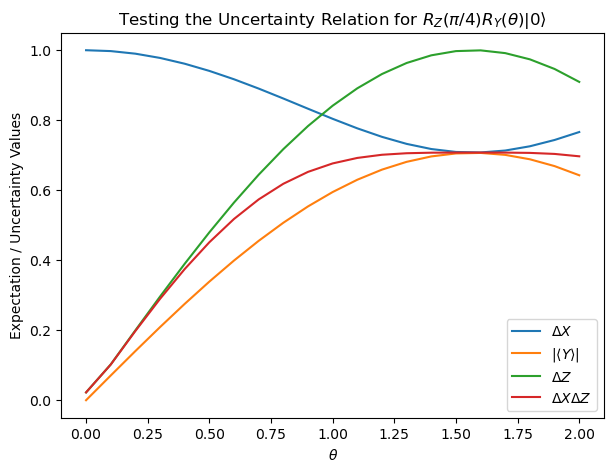

In [42]:
plt.figure(figsize=(7, 5))
plt.plot(params, delx, label=r"$\Delta X$")
plt.plot(params, ys, label=r"$|\langle Y \rangle|$")
plt.plot(params, delz, label=r"$\Delta Z$")
plt.plot(params, prodxz, label=r"$\Delta X \Delta Z$")

plt.xlabel(r"$\theta$")
plt.ylabel("Expectation / Uncertainty Values")
plt.title(r"Testing the Uncertainty Relation for $R_Z(\pi/4)R_Y(\theta)|0\rangle$")
plt.legend()

plt.savefig("uncertainty_relation_with_phase.png")
plt.show()

The uncertainty relation $\Delta X\,\Delta Z \ge |\langle Y\rangle|$ is satisfied everywhere here (red curve always greater than or equal to orange curve), and see equality near $\theta=\pi/2$.

$\Delta X\,\Delta Z \ge |\langle Y\rangle|$ is satisfied throughout here, but is $\Delta X\Delta Y \ge \frac{1}{2} |\langle [X,Y]\rangle|$?

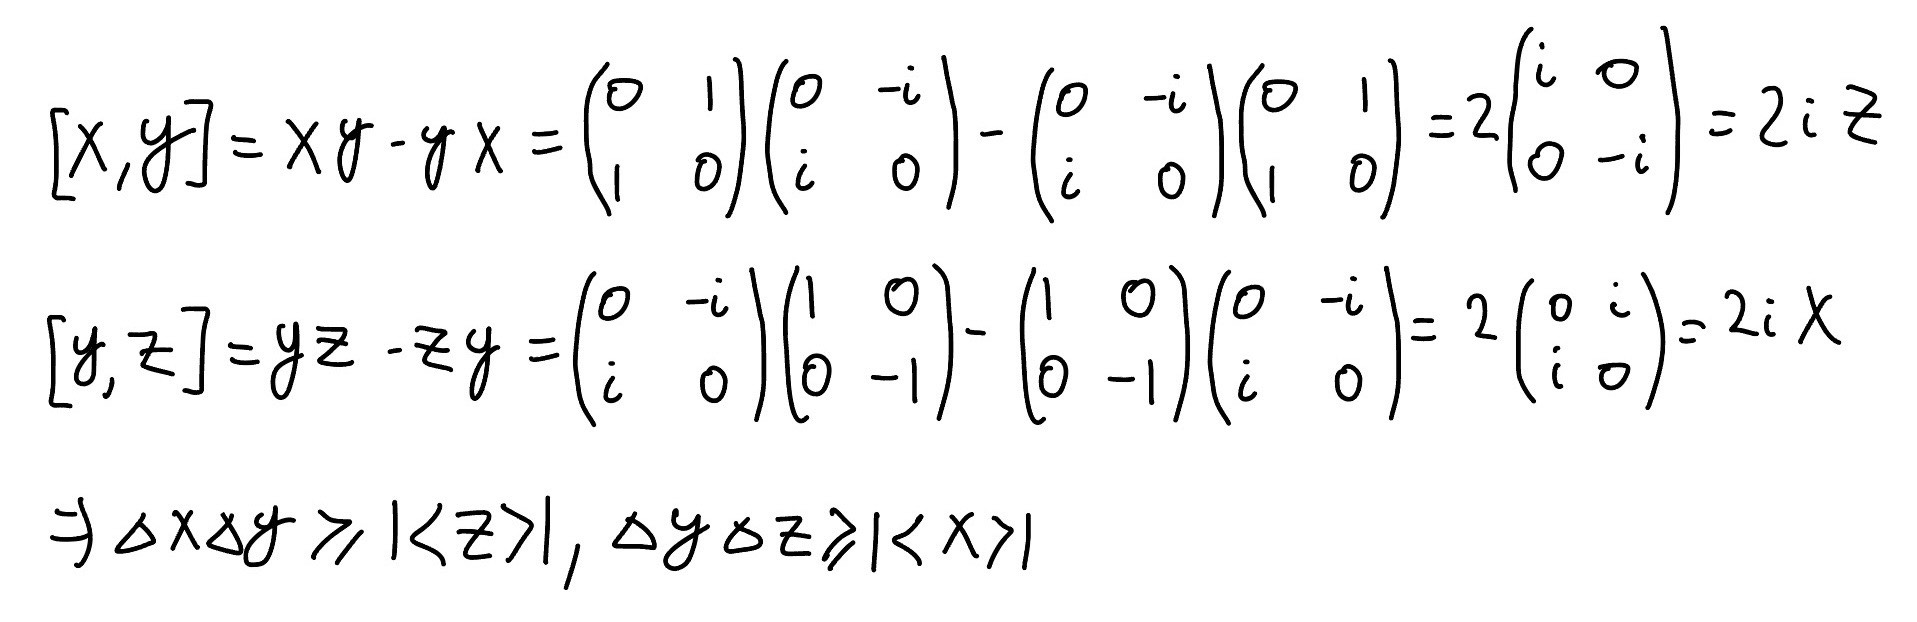

In [29]:
Image('XYYZ.jpeg')

In [31]:
xs=res[0].data.evs[0]
ys=res[0].data.evs[1]
zs=abs(res[0].data.evs[2])

delx = []
dely = []
prodxy=[]
for i in range(len(xs)):
    delx.append((1-xs[i]*xs[i])**0.5)
    dely.append((1-ys[i]*ys[i])**0.5)
    prodxy.append(((1-xs[i]*xs[i])**0.5)*(1-ys[i]*ys[i])**0.5)


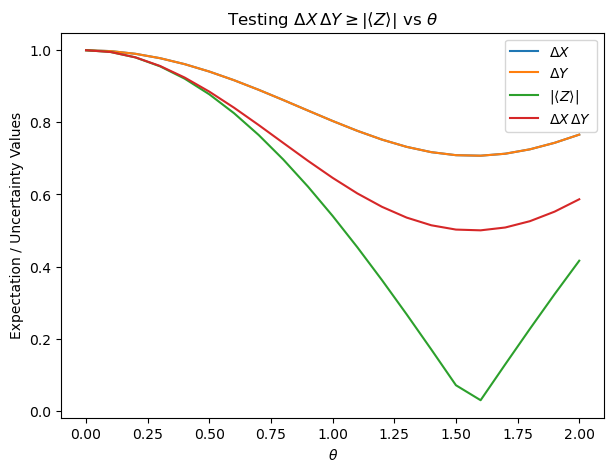

In [33]:
plt.figure(figsize=(7, 5))
plt.plot(params, delx,   label=r"$\Delta X$")
plt.plot(params, dely,   label=r"$\Delta Y$")
plt.plot(params, zs,     label=r"$|\langle Z \rangle|$")
plt.plot(params, prodxy, label=r"$\Delta X\,\Delta Y$")

plt.xlabel(r"$\theta$")
plt.ylabel("Expectation / Uncertainty Values")
plt.title(r"Testing $\Delta X\,\Delta Y \geq |\langle Z\rangle|$ vs $\theta$") 
plt.legend()
plt.savefig("uncertainty_relation_XY_vs_theta.png")
plt.show()

The uncertainty relation $\Delta X\,\Delta Y \ge |\langle Z\rangle|$ is satisfied everywhere here (red curve always greater than or equal to green curve), and see equality near $\theta=0$.

## Large $\langle Y\rangle$ limit

To get largest $\langle Y\rangle$ possible, must rotate into the $y$ plane, by rotating around $z$ by $\pi/2$ (or for large $|\langle Y\rangle|$ limit, rotate around $z$ by either $\pi/2$ or $3\pi/2$).

In [47]:
# The calculation below uses approximately 3-4 minutes of QPU time.
# Step 1: Map the problem to a quantum circuit
 
# Specify observables
obs1 = SparsePauliOp("X")
obs2 = SparsePauliOp("Y")
obs3 = SparsePauliOp("Z")
 
# Define registers
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
 
# Rotate away from |0> along one plane, and then along a transverse direction.
theta = Parameter("θ")
qc.ry(theta, 0)
qc.rz(pi / 2, 0)
 
params = np.linspace(0, 2, num=21)
 
# Step 2: Transpile the circuit
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
 
obs1_isa = obs1.apply_layout(layout=qc_isa.layout)
obs2_isa = obs2.apply_layout(layout=qc_isa.layout)
obs3_isa = obs3.apply_layout(layout=qc_isa.layout)
 
# Step 3: Run the circuit on a real quantum computer
 
#with Batch(backend=backend) as batch:
#    estimator = Estimator(mode=batch)
#    pubs = [(qc_isa, [[obs1_isa], [obs2_isa], [obs3_isa]], [params])]
#    job = estimator.run(pubs, precision=0.01)
#    res = job.result()
 
#batch.close()
 
# Run the job on the Aer simulator with noise model from real backend
 
job = noisy_estimator.run([(qc_isa, [[obs1_isa], [obs2_isa], [obs3_isa]], [params])])
res=job.result()

In [48]:
# Step 4: Post-processing and classical analysis.
xs = res[0].data.evs[0]
ys = abs(res[0].data.evs[1])
zs = res[0].data.evs[2]
 
# Calculate uncertainties
 
delx = []
delz = []
prodxz = []
for i in range(len(xs)):
    delx.append(abs((1 - xs[i] * xs[i])) ** 0.5)
    delz.append(abs((1 - zs[i] * zs[i])) ** 0.5)
    prodxz.append(delx[i] * delz[i])

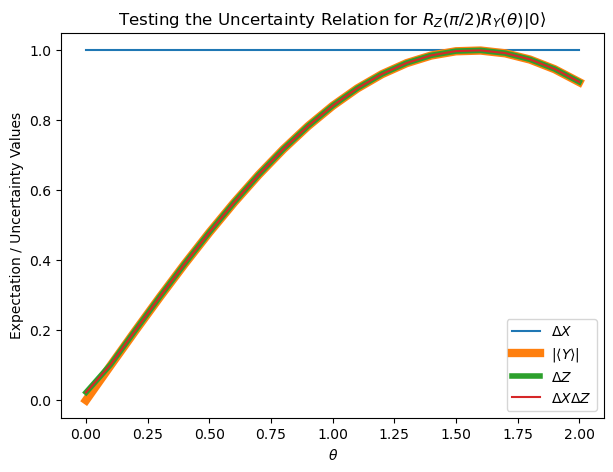

In [49]:
plt.figure(figsize=(7, 5))
plt.plot(params, delx, label=r"$\Delta X$")
plt.plot(params, ys, label=r"$|\langle Y \rangle|$", linewidth=6)
plt.plot(params, delz, label=r"$\Delta Z$", linewidth=4)
plt.plot(params, prodxz, label=r"$\Delta X \Delta Z$")

plt.xlabel(r"$\theta$")
plt.ylabel("Expectation / Uncertainty Values")
plt.title(r"Testing the Uncertainty Relation for $R_Z(\pi/2)R_Y(\theta)|0\rangle$")
plt.legend()

plt.savefig("uncertainty_relation_y_eigenstate.png")
plt.show()

The uncertainty relation $\Delta X\,\Delta Z \ge |\langle Y\rangle|$ is satisfied everywhere here (red curve always greater than or equal to orange curve), and since all states are in the $yz$ plane, $\Delta X\,\Delta Z = |\langle Y\rangle|$.

$\langle Y\rangle$ is largest (equal to $1$), when the state exactly in an eigenstate $|+i\rangle$, when $\theta=\pi/2$.

#### 3-D Plot

To completely generalize this analysis on the bloch sphere, now consider uncertainty in a 3-D plot with $\theta\in[0,\pi],\phi\in[0,2\pi]$. This can easily done using expectation values of a general bloch vector.

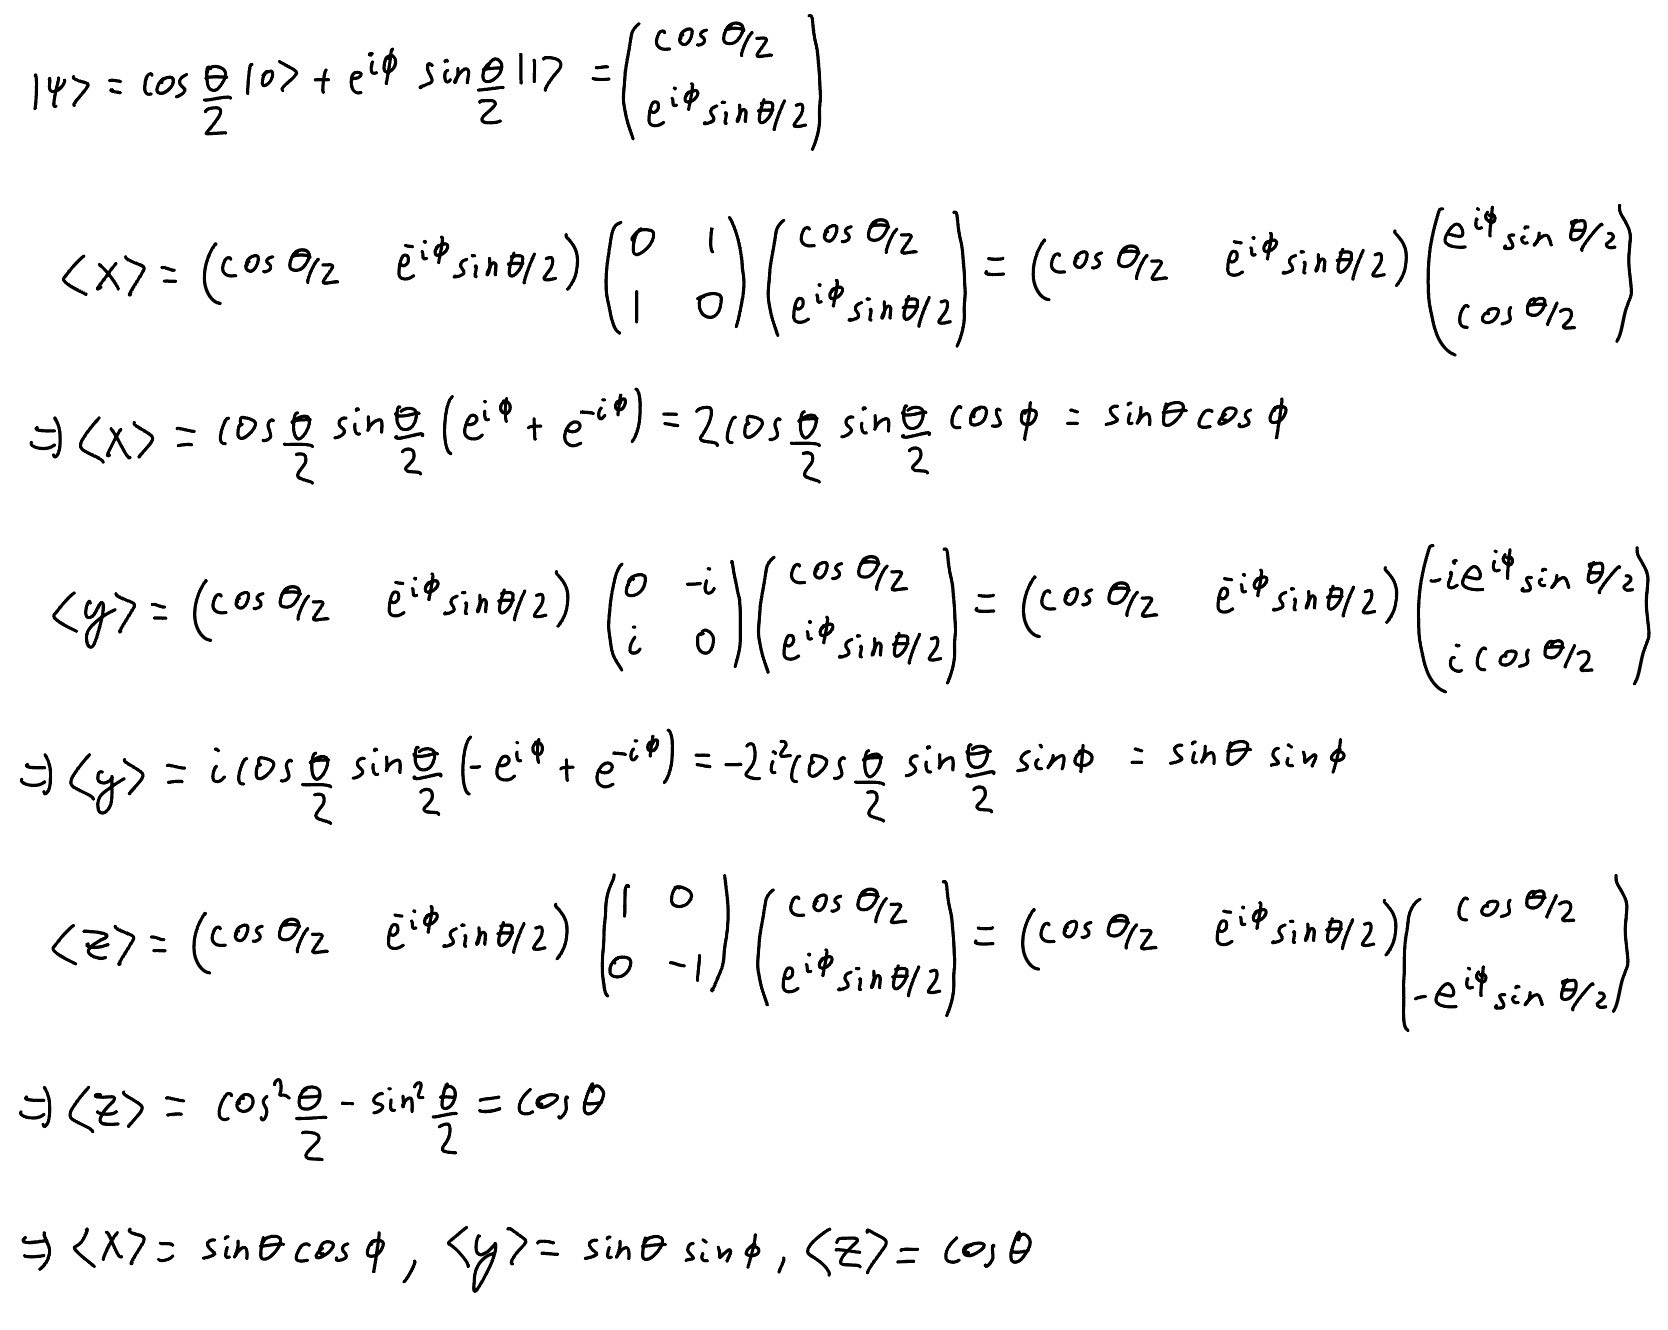

In [3]:
Image('vector_exp.jpeg')

Rather than plotting two curves on top of each other, which can hide features, the margin $\Delta X\Delta Z - |\langle Y\rangle|$. This quantity should be non-negative everywhere if the uncertainty relation is satisfied, and equals 0 exactly where $\Delta X\Delta Z = |\langle Y\rangle|$.

Equality should be seen when the state is in the $yz$ or $xy$ plane, $z=0$ ($\theta=\pi/2$), $x=0$ (either $\theta=0,\pi$ or $\phi=\pi/2,3\pi/2$).

Maximum difference should be seen when the state is in the $xz$ plane, which occurs when $\theta=\pi/4,3\pi/4$ and $\phi=0,\pi,2\pi$.

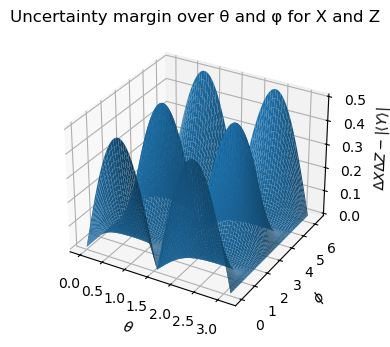

In [31]:
theta = np.linspace(0.0, np.pi, 181) #covers from top to bottom
phi   = np.linspace(0.0, 2*np.pi, 361) #covers full circle around z
TH, PH = np.meshgrid(theta, phi) #required for 3D plot

xs = np.sin(TH) * np.cos(PH)
ys = np.sin(TH) * np.sin(PH)
zs = np.cos(TH)

delx = np.sqrt(1 - xs**2)
delz = np.sqrt(1 - zs**2)

M = delx * delz - np.abs(ys)


fig = plt.figure(figsize=(3.8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(TH, PH, M, rstride=3, cstride=3) 
# r means every 3rd row, c means every 3rd column, looks neatest this way

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\phi$")
ax.set_zlabel(r"$\Delta X \Delta Z - |\langle Y\rangle|$")
ax.set_title("Uncertainty margin over θ and φ for X and Z")


plt.show()

Peaks and troughs exactly where expected!

## Questions

**True/False Questions**

1. *One can simultaneously measure* $X$ *and* $Y$, *but not* $Z$.

**False** $X$ and $Y$ do not commute, so they have no common eigenbasis and cannot be measured simultaneously with definite outcomes.

2. *One can simultaneously measure* $X$ *and* $Z$, *but not* $Y$.

**False** $X$ and $Z$ do not commute, so they also cannot be measured simultaneously with definite outcomes.

3. *Linear position and linear momentum operators do not commute.*

**True**, linear position and linear momentum satisfy $[x,p]=i\hbar \neq 0$ so they do not commute.

4. *IBM quantum computers measure along* $Z$ *by default, so a rotation must be performed to measure along any other direction.*

**True** IBM devices measure in the computational basis $Z$ by default. To measure along another axis you apply a basis change (such as applying a Hadamard gate which swaps $x$ and $z$ axes) then measure in $Z$.

4. *The circuit below effectively measures* $Z$ and then $X$.

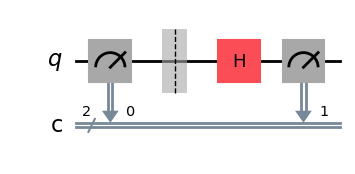

In [32]:
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
 
qc.measure(qr, cr[0])
qc.barrier()
qc.h(qr)
qc.measure(qr, cr[1])
 
qc.draw("mpl")

**True**, as seen earlier, will measure $0$ in $Z$, then $0$ or $1$ with equal probability in $X$.

**Multiple Choice Questions**

1. *The diagram below demonstrates which of the following uncertainty relations?*

*a.* $\Delta X\,\Delta Y \ge |\langle Z\rangle|$

*b.* $\Delta Y\,\Delta Z \ge |\langle X\rangle|$

*c.* $\Delta Z\,\Delta X \ge |\langle Y\rangle|$

*d. None of the above*


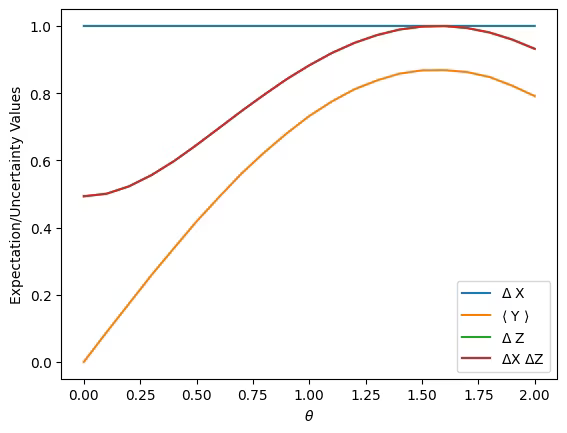

In [33]:
Image('checkin.png')

**c** since the $\langle Y \rangle$ (orange line) is always less than $\Delta X \Delta Z$ (red line)

2. *Which of the following is the standard sequence to perform a measurement along* $x$?

*a. Only* qc.measure()

*b.* qc.h() *then* qc.measure()

*c.* qc.h(), qc.h() *then* qc.measure()

*d.* qc.h(), qc.s, qc.h() *then* qc.measure()

*e.* qc.sdg(), qc.h(), qc.s *then* qc.measure()

*f.* qc.sdg(), qc.h(), qc.s, qc.h() *then* qc.measure()

**b** since Hadamard gate swaps $z$ and $x$ axes.

3. *Which of the following states yields the largest expectation value* $\langle X \rangle$?

*a.* $|+\rangle_x$

*b.* $|-\rangle_x$

*c.* $|+\rangle_y$

*d.* $|-\rangle_y$

*e.* $|0\rangle$

*f.* $|1\rangle$

**a**, both $|+\rangle_x$ and $|-\rangle_x$ are eigenstates of $X$, so both have the same absolute value $|\langle X \rangle|=1$, but $|+\rangle_x$ has $\langle X \rangle=1$, and $|-\rangle_x$ has $\langle X \rangle=-1$.

4. *Which of the following states yields the largest uncertainty* $\Delta X$?

*a.* $|+\rangle_x$

*b.* $|+\rangle_y$

*c.* $|0\rangle$

*d. a and b are tied*

*e. b and c are tied*

*f. a,b, and c are tied*

**e** as $|+\rangle_y$ and $|0\rangle$ are eigenstates of operators ($Y$ and $Z$ respectively) that don't commute with $X$.

**Discussion Questions**

**Discussion Questions and Suggested Answers**

1. *Does this concept of uncertainty conflict in any way with the notion of spin as a vector arrow in Cartesian space? How about on the Bloch sphere?*  


Yes, the concept of quantum uncertainty is in conflict with viewing spin as a classical vector with definite components in Cartesian space, but it is perfectly consistent with the Bloch sphere representation. In classical space a vector has definite components along $x$, $y$, and $z$ simultaneously. For a spin-1/2 particle, the quantities $S_x,S_y,S_z$ correspond to non-commuting operators, so the spin cannot possess definite values of all three simultaneously.

On the Bloch sphere, a spin state is represented by a Bloch vector whose components are the expectation values $\langle \sigma_x \rangle, \langle \sigma_y \rangle, \langle \sigma_z \rangle$. These encode the statistics of measurement outcomes, not pre-existing definite components. A projective measurement along one axis collapses the state and destroys previous information about components along orthogonal axes. The Bloch sphere is therefore fully consistent with quantum uncertainty. The length of the Bloch vector equals one for pure states and less than one for mixed states, reflecting the purity of the state rather than the presence of classical spin components.

2. *Suppose you orient a measurement device along a direction half-way between the $x$ and $y$ axes. What happens? Can you make a measurement along this direction? How does this relate to uncertainty in $X$ and $Y$?*

Yes, any axis on the Bloch sphere corresponds to a valid spin measurement. A measurement device aligned halfway between the x and y axes measures the observable $M = \frac{X + Y}{\sqrt{2}}$. The possible outcomes are still $\pm1$, with eigenstates whose Bloch vectors point along this halfway direction.

This does not provide simultaneous definite values of $X$ and $Y$, instead, it defines a new basis associated with $M$. Since $X$ and $Y$ do not commute, an eigenstate of $M$ has uncertainty in $X$ and $Y$, so their individual outcomes remain probabilistic. Measuring along the halfway direction is fully allowed, but the uncertainty relation between $X$ and $Y$ is still satisfied.

3. *What additional experiments would you like to do to convince yourself of the results obtained here?** 
   - Perform measurements along intermediate directions to confirm the continuous transition between $X$, $Y$, and $Z$ bases.  
   - State Tomography try to fully reconstruct an unknown quantum state by determining its Bloch vector.

#### Continuous Transitions

For an arbitrary initial state $|\psi\rangle=R_Z(\pi/5.2)R_Y(\pi/2.5)|0\rangle$ (with projection on all axes), is there continuous transitions between $X$, $Y$, and $Z$ bases, when performing measurements along intermediate directions?

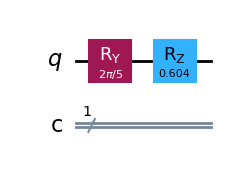

In [15]:
# Map the problem to a quantum circuit

qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
qc.ry(np.pi/2.5, 0)
qc.rz(np.pi/5.2, 0)
# initial state has projection on all axes

qc.draw("mpl")

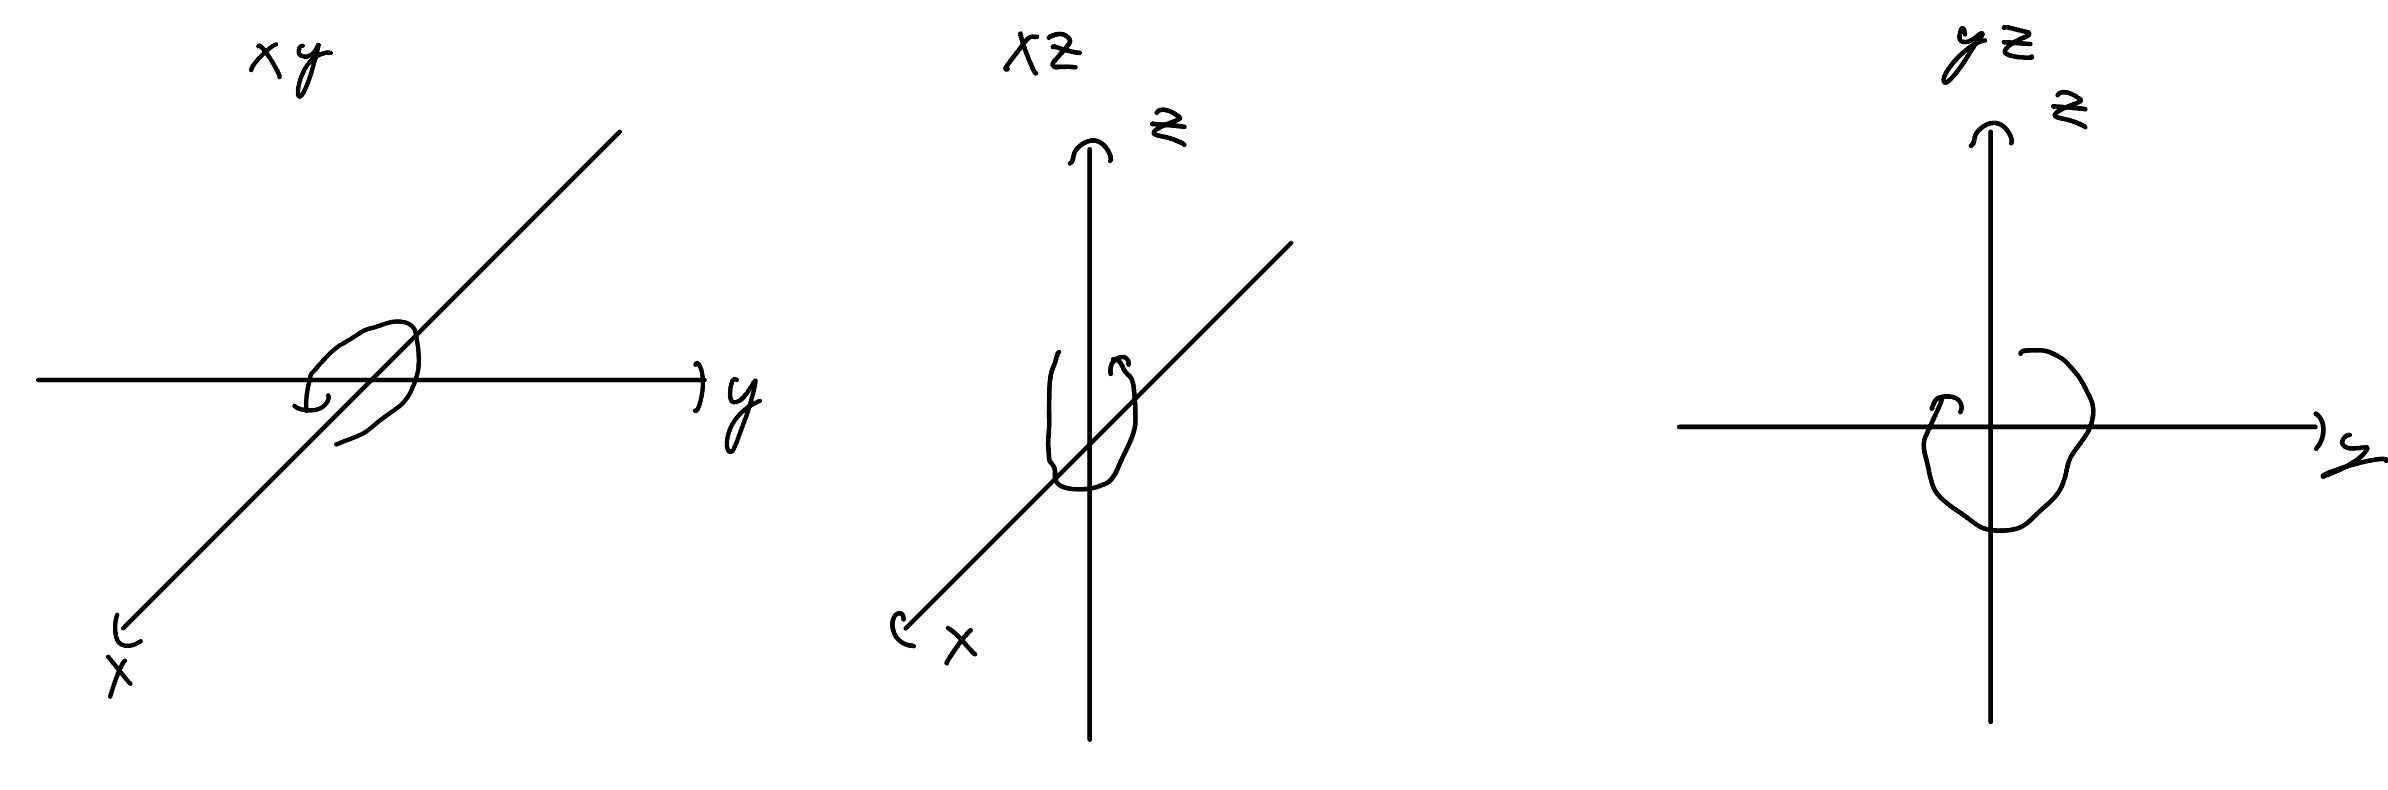

In [10]:
Image('axes.jpg')

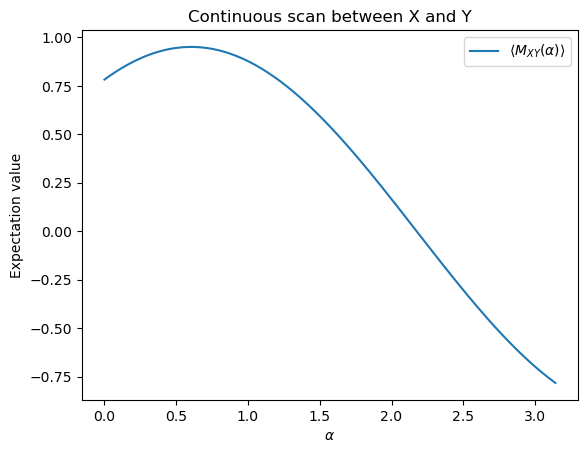

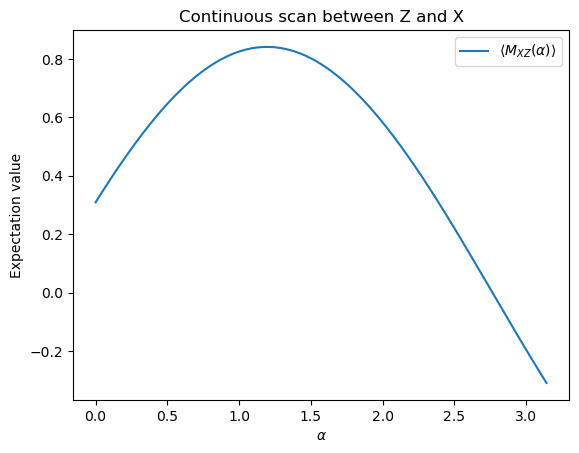

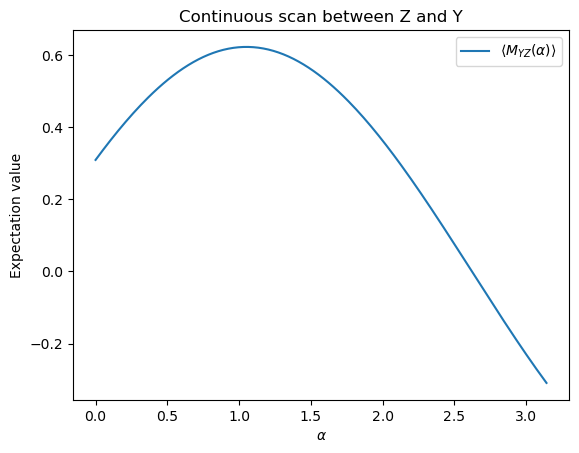

In [17]:
# Transpile the circuit
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)

# continuous intermediate axis observables, shown above (half rotation), 
#since pm n corresponds to same axis up to swapping outcome labels

alphas=np.linspace(0, np.pi, 181)     

xy_obs = [SparsePauliOp.from_list([("X", np.cos(alpha)), ("Y", np.sin(alpha))]) for alpha in alphas]

xz_obs = [SparsePauliOp.from_list([("X", np.sin(alpha)), ("Z", np.cos(alpha))]) for alpha in alphas]

yz_obs = [SparsePauliOp.from_list([("Y", np.sin(alpha)), ("Z", np.cos(alpha))]) for alpha in alphas]

# map all observables 
xy_obs_isa = [obs.apply_layout(layout=qc_isa.layout) for obs in xy_obs]
xz_obs_isa = [obs.apply_layout(layout=qc_isa.layout) for obs in xz_obs]
yz_obs_isa = [obs.apply_layout(layout=qc_isa.layout) for obs in yz_obs]


# Run the job on the Aer simulator with noise model from real backend
job = noisy_estimator.run([(qc_isa, xy_obs_isa, []),(qc_isa, xz_obs_isa, []),(qc_isa, yz_obs_isa, []),])
#Estimator V2 PUB format: (<circuit>, <observables>, <parameter values>, <precision>) (from IBM)

res = job.result()

evs = np.array(res[0].data.evs)

# Post-processing

xys = res[0].data.evs  
xzs = res[1].data.evs 
yzs = res[2].data.evs  

# Plots

plt.figure()
plt.plot(alphas, xys, label=r"$\langle M_{XY}(\alpha)\rangle$")
plt.xlabel(r"$\alpha$")
plt.ylabel("Expectation value")
plt.title("Continuous scan between X and Y")
plt.legend()
plt.savefig("estimator_scan_XY.png")
plt.show()

plt.figure()
plt.plot(alphas, xzs, label=r"$\langle M_{XZ}(\alpha)\rangle$")
plt.xlabel(r"$\alpha$")
plt.ylabel("Expectation value")
plt.title("Continuous scan between Z and X")
plt.legend()
plt.savefig("estimator_scan_XZ.png")
plt.show()

plt.figure()
plt.plot(alphas, yzs, label=r"$\langle M_{YZ}(\alpha)\rangle$")
plt.xlabel(r"$\alpha$")
plt.ylabel("Expectation value")
plt.title("Continuous scan between Z and Y")
plt.legend()
plt.savefig("estimator_scan_YZ.png")
plt.show()

Measurements along arbitrary intermediate directions on the Bloch sphere are well-defined, and their expectation values vary continuously as the axis is rotated.

#### State Tomography

Try to find $\langle X\rangle,\langle Y\rangle,$ and $\langle Z\rangle$ for the state $|\psi\rangle=R_Z(\pi/5.2)R_Y(\pi/2.5)|0\rangle$.

Given preparation $|\psi\rangle=R_Z(\phi)R_Y(\theta)|0\rangle$,$\langle X\rangle = \sin\theta\cos\phi,\langle Y\rangle = \sin\theta\sin\phi,\langle Z\rangle = \cos\theta.$

$\Rightarrow\langle X\rangle \approx \sin\left(\frac{\pi}{2.5}\right)\cos\left(\frac{\pi}{5.2}\right) \approx 0.7827,\langle Y\rangle \approx \sin\left(\frac{\pi}{2.5}\right)\sin\left(\frac{\pi}{5.2}\right) \approx 0.5403,\langle Z\rangle = \cos\left(\frac{\pi}{2.5}\right) = 0.3090.$


This could easily be done using an estimator as well, but since the noisy_simulator was defined earlier and has not been used yet, the simulator is used below.

In [30]:
qr = QuantumRegister(1, "q")
cr = ClassicalRegister(1, "c")

qc = QuantumCircuit(qr, cr)
qc.ry(np.pi/2.5, 0)
qc.rz(np.pi/5.2, 0)

# Measurement circuits for Z, X, Y
# measures in Z by default
qc_z = qc.copy()
qc_z.measure(0, 0)

# apply hadamard to measure in X
qc_x = qc.copy()
qc_x.h(0)
qc_x.measure(0, 0)


qc_y = qc.copy()
# rotate Y to X then apply Hadamard to Z, measure in Y
qc_y.rz(-np.pi/2, 0)
qc_y.h(0)
qc_y.measure(0, 0)

# Transpile once
pm = generate_preset_pass_manager(optimization_level=3)
circs_isa = pm.run([qc_z, qc_x, qc_y])

#sampler_sim = BackendSamplerV2(backend=backend_sim)
res = noisy_sampler.run(circs_isa,shots=4000).result()


Zres, Xres, Yres = res 

def exp(r):
    counts = r.data.c.get_counts()
    s = sum(counts.values())
    return counts.get("0", 0) / s - counts.get("1", 0) / s
# exp(Z)=P(0)(1)+P(1)(-1)

zs = exp(Zres)
xs = exp(Xres)
ys = exp(Yres)

print(xs,ys,zs)

0.778 0.5329999999999999 0.318


$\Rightarrow \langle X\rangle=r_x\approx0.778,\langle Y\rangle=r_y\approx0.533,\langle Z\rangle=r_z\approx0.318$ (with bloch vector $\mathbf{r}=(r_x,r_y,r_z)$, which is close to the calculated values, $\langle X\rangle \approx \sin\left(\frac{\pi}{2.5}\right)\cos\left(\frac{\pi}{5.2}\right) \approx 0.7827,\langle Y\rangle \approx \sin\left(\frac{\pi}{2.5}\right)\sin\left(\frac{\pi}{5.2}\right) \approx 0.5403,\langle Z\rangle = \cos\left(\frac{\pi}{2.5}\right) = 0.3090$

## Conclusion

In this lab, real and noise modelled quantum hardware were used to show that uncertainty relations are not abstract inequalities, and they appear directly in qubit experiments. By preparing one-qubit states and changing measurement bases with single-qubit rotations, it was confirmed that measuring one Pauli observable (for example $X$) destroys information about non-commuting observables (such as $Z$), while eigenstates of a given Pauli operator have zero uncertainty in that observable and maximal uncertainty in the others.

Using the Sampler and Estimator primitives, expectation values $\langle X\rangle, \langle Y\rangle, \langle Z\rangle$ were found, Bloch vectors were reconstructed, and standard deviations $\Delta X, \Delta Y, \Delta Z$ were computed for different states and intermediate measurement directions. Across all cases, the generalized uncertainty bounds, such as $\Delta X\,\Delta Z \ge |\langle Y\rangle|$, were satisfied and saturated exactly where predicted, demonstrating that quantum uncertainty is an intrinsic feature of qubit states and incompatible measurements.